# Requirements

In [2]:
import os

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import cv2

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A
from torch.autograd import Variable

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <A0E0B741-848C-3144-924F-2971884DA4EF> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <6384E44A-E10D-30C9-994F-E34B0519E5B3> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Data

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, transforms = None, padding = None):
        super().__init__()
        self.paths = paths
        self.transforms = transforms
        self.pad = padding
        
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, ind):
        
        img = cv2.imread(paths[ind])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.pad != None:
            img = self.pad(image = img)['image']
            
        if self.transforms != None:
            img = self.transforms(img)
        
        return img

In [4]:
root_dir = 'naruto-face-dataset'

In [5]:
paths = []

In [6]:
for folder in os.listdir(root_dir):
    if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
        continue
    folder_path = os.path.join(root_dir, folder)
    for file in os.listdir(folder_path):
        if file == '.DS_Store' or file == '.ipynb_checkpoints':
            continue
        paths.append(os.path.join(folder_path, file))

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [8]:
dataset = Dataset(paths)

Show some samples from dataset

In [9]:
n_samples = 6
cols = 3

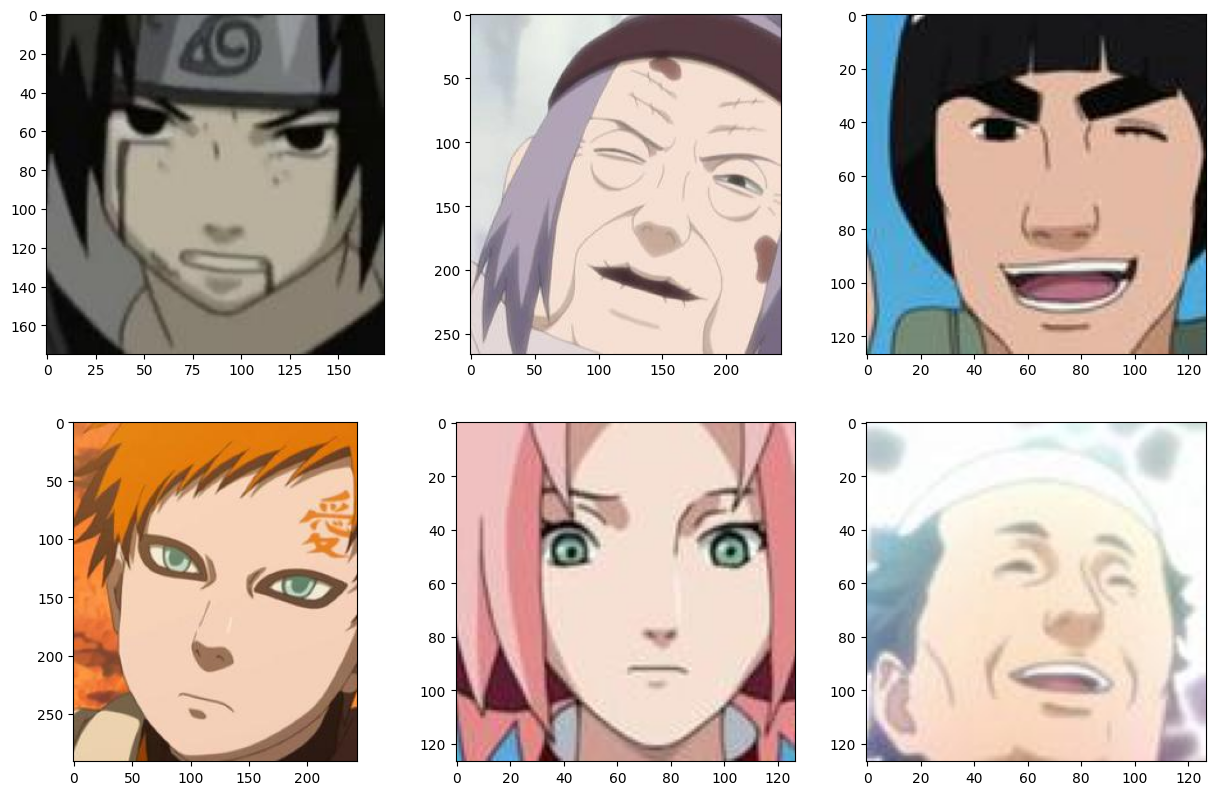

In [10]:
plt.figure(figsize=(15,15))
for i in range(n_samples):
    img = dataset[i]
    plt.subplot(n_samples//cols + 1, cols, i + 1)
    plt.imshow(img)

# Data Processing

In [11]:
image_size = 128 
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(size = (image_size, image_size)),
    ])
pad = A.Compose([
    A.PadIfNeeded(image_size, image_size, value = 0)
])

In [12]:
transformed_dataset = Dataset(paths, transforms, pad)

# Model

In [40]:
def weights_init_xavier(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, image_size, channels):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.model = nn.Sequential(
            nn.Conv2d(self.channels, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8)
        )

        # The height and width of downsampled image
        self.img_size = image_size
        ds_size = self.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [32]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size, channels):
        super(Generator, self).__init__()

        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [131]:
lattent_dim = 256
image_size = 128
lr = 1e-6
n_epochs = 10
batch_size = 32
sample_interval = 100
channels = 3

In [132]:
adversarial_loss = torch.nn.BCELoss()

In [133]:
generator = Generator(
    image_size = image_size,
    latent_dim = lattent_dim,
    channels = channels)
discriminator = Discriminator(
    image_size = image_size,
    channels = channels)

In [134]:
generator.apply(weights_init_xavier)
discriminator.apply(weights_init_xavier)

/var/folders/sm/zp4frk3174zc8vhh_l6v9byh0000gn/T/ipykernel_65462/2054984732.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [135]:
optimizer_G = torch.optim.AdamW(generator.parameters(), lr=lr)
optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=lr)

In [136]:
dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size = batch_size, shuffle = True)

In [130]:
for epoch in range(n_epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    i = 0
    for imgs in tqdm(dataloader):

        valid = Variable(torch.Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(torch.float))

        optimizer_G.zero_grad()

        z = Variable(torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], lattent_dim))).type(torch.float))

        gen_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
         
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            torchvision.utils.save_image(gen_imgs.data[:25], f"gan_images/{batches_done}.png", nrow=5, normalize=True)
        
        i += 1
    epoch_g_loss /= g_loss.item()
    epoch_d_loss /= d_loss.item()
    
    print(f"Epoch {epoch} D loss: {epoch_d_loss} G loss: {epoch_g_loss}")


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 0 D loss: 222.75381604849647 G loss: 225.98319403565156


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 1 D loss: 219.86845250512846 G loss: 221.71006727757552


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 2 D loss: 226.3965350641847 G loss: 217.5807548629985


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 3 D loss: 221.91237916650127 G loss: 220.50900621523184


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 4 D loss: 219.71428799716315 G loss: 223.8157494093548


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 5 D loss: 220.88023379894315 G loss: 213.87503996010193


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 6 D loss: 222.39112571579977 G loss: 221.4189279636832


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 7 D loss: 223.27804272005542 G loss: 222.22027908512075


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 8 D loss: 219.21680007954637 G loss: 220.4880457772472


  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 9 D loss: 222.30241520050043 G loss: 217.4377803381337


In [105]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], lattent_dim))).type(torch.float))

gen_imgs = generator(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


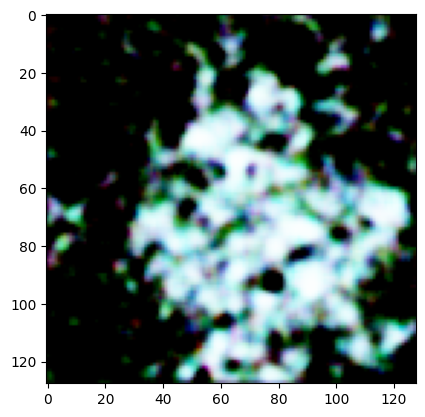

In [106]:
plt.imshow(gen_imgs[0].permute(1,2,0).detach().numpy())